# 导包

In [2]:
import torch
import os,re
import pickle
from collections import defaultdict
from transformers import AutoTokenizer
import transformers
from tqdm import tqdm
import torch
import torch.nn as nn
import math
from transformers import AutoModel
tokenizer=AutoTokenizer.from_pretrained("/home/xhsun/Desktop/huggingfaceModels/chinese-roberta-wwm/")

# 读取知识图谱

In [63]:
ent2id = {}
with open('/home/xhsun/Desktop/KG/nlpcc2018/knowledge/small_knowledge_bk/entities.dict') as f:
    lines=f.readlines()
for i in tqdm(range(len(lines))):
    l = lines[i].strip().split('\t')
    ent2id[l[0].strip()] = len(ent2id)
    
rel2id = {}
with open('/home/xhsun/Desktop/KG/nlpcc2018/knowledge/small_knowledge_bk/relations.dict') as f:
    lines=f.readlines()
for i in tqdm(range(len(lines))):
    l = lines[i].strip().split('\t')
    rel2id[l[0].strip()] = int(l[1])

triples = []
sub_map = defaultdict(list)
with open('/home/xhsun/Desktop/KG/nlpcc2018/knowledge/small_knowledge_bk/small_kb') as f:
    lines=f.readlines()
for i in tqdm(range(len(lines))):
    l = lines[i].strip().split('|||')
    s = ent2id[l[0].strip()]
    p = rel2id[l[1].strip()]
    o = ent2id[l[2].strip()]
    sub_map[l[0].strip()].append((l[1].strip(),l[2].strip()))
    triples.append((s, p, o))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 369812/369812 [00:00<00:00, 613958.18it/s]


In [8]:
print('知识图谱中一共有{}个三元组，{}个实体，{}个关系'.format(len(triples),len(ent2id),len(rel2id)))

知识图谱中一共有369812个三元组，190912个实体，3906个关系


- ent2id指的是每一个实体与对应的id之间的映射
- rel2id指的是每一个关系与对应的id之间的映射
- triples代表所有三元组的集合，每一个元素是一个三元组，其中头实体、尾实体和关系均用对应的id表示

In [9]:
print(ent2id['笑傲江湖'],rel2id['作者'],ent2id['金庸'])

68286 826 142061


In [10]:
triples.index((68286,826,142061))

253454

可以看出，(笑傲江湖，作者，金庸)这个三元组是整个triples集合中的第253455个三元组

In [11]:
triples[253454]

(68286, 826, 142061)

# 获取模型输入

从源代码中可以看出，模型有4个输入参数：
1. heads
2. questions
3. answers
4. entity_range

以如下句子为例：
{"question": "谁知道<解构金庸>的人号称什么啊？", "topic_entity": "解构金庸", "answer": "武林百晓生”", "relation": "号称"}

In [12]:
question="谁知道<解构金庸>的人号称什么啊？"
head='解构金庸'
question=question.replace('<'+head+'>','NE')
print(question)
answer='武林百晓生”'

head_id=ent2id[head]
answer_id=ent2id[answer]
question_ids=tokenizer(question)
print('问题中的topic entity是"{}"，它在实体集合中的id是{}'.format(head,head_id))
print('该问题的答案是"{}"，它在实体集合中的id是{}'.format(answer,answer_id))
print('将问题中的每一个单词转换为对应的id：\n',question_ids)

for key,value in question_ids.items():
    question_ids[key]=torch.LongTensor([value])

谁知道NE的人号称什么啊？
问题中的topic entity是"解构金庸"，它在实体集合中的id是12882
该问题的答案是"武林百晓生”"，它在实体集合中的id是51665
将问题中的每一个单词转换为对应的id：
 {'input_ids': [101, 6443, 4761, 6887, 10564, 4638, 782, 1384, 4917, 784, 720, 1557, 8043, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


**问题中单词的id是vocab.txt中的id，与知识图谱中实体的id无关**

# 模型的前向传播

## 模型的参数

- Encoder 就是BERT，维度是768
- $f^t$ 代表第$t$个step的projection function，论文中$t$设置为2，所以就是有两个映射层，每一个映射层由MLP+Tanh组成
- 关系分类器 就是一个普通的线性分类器，用来预测KG中哪些关系与问题最相关

In [43]:
################################################################################################################
num_relations=len(rel2id)
Tsize = len(triples)
Esize = len(ent2id)
triples = torch.LongTensor(triples)
num_steps=2
ent_probs=[]
################################################################################################################
encoder=AutoModel.from_pretrained("/home/xhsun/Desktop/huggingfaceModels/chinese-roberta-wwm/",return_dict=True)
step_1_projection=nn.Sequential(nn.Linear(768,768),nn.Tanh())
step_2_projection=nn.Sequential(nn.Linear(768,768),nn.Tanh())
relation_classifier=nn.Linear(768,num_relations)
hop_selector = nn.Linear(768, num_steps)
################################################################################################################
idx = torch.LongTensor([i for i in range(Tsize)])
Msubj = torch.sparse.FloatTensor(
    torch.stack((idx, triples[:,0])), torch.FloatTensor([1] * Tsize), torch.Size([Tsize, Esize]))
Mobj = torch.sparse.FloatTensor(
    torch.stack((idx, triples[:,2])), torch.FloatTensor([1] * Tsize), torch.Size([Tsize, Esize]))
Mrel = torch.sparse.FloatTensor(
    torch.stack((idx, triples[:,1])), torch.FloatTensor([1] * Tsize), torch.Size([Tsize, num_relations]))

Some weights of the model checkpoint at /home/xhsun/Desktop/huggingfaceModels/chinese-roberta-wwm/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 计算关于问题的attention向量$q^t$
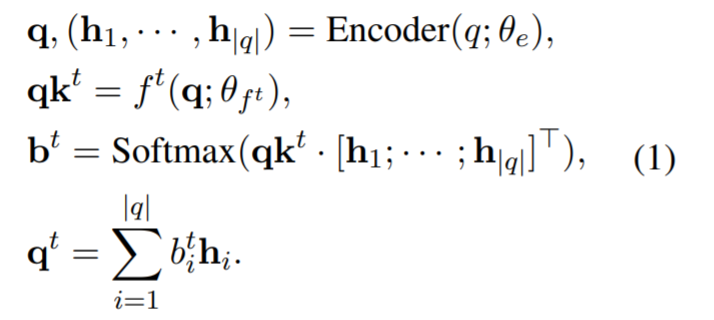

In [44]:
bert_output=encoder(**question_ids)
q_embeddings,context_embeddings=bert_output.pooler_output,bert_output.last_hidden_state

In [45]:
print("句子嵌入：",q_embeddings.size(),"上下文嵌入：",context_embeddings.size())

句子嵌入： torch.Size([1, 768]) 上下文嵌入： torch.Size([1, 14, 768])


In [46]:
qk_1=step_1_projection(q_embeddings)
b_1=torch.softmax(torch.sum(qk_1.unsqueeze(1)*context_embeddings,dim=2),dim=1)
q_1=torch.sum(b_1.unsqueeze(2)*context_embeddings,dim=1)

**$q^t$是问题感知(question-aware)的语义向量，它关注了问题的不同部分，即蕴含着问题所要询问的信息**

## 根据$q^t$计算关系分数(也就是计算KG中哪一个关系与该问题最相关)

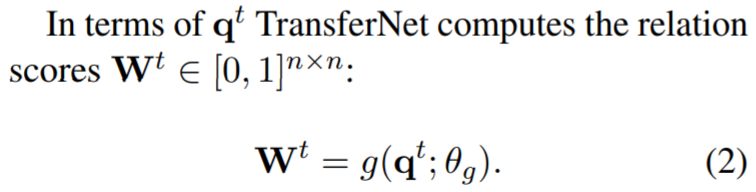
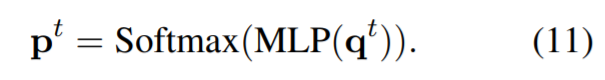
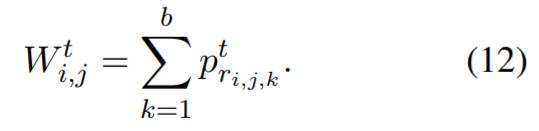

In [47]:
p_1=torch.sigmoid(relation_classifier(q_1))

## 利用p_1实现hop

### TransferNet infers the answer by transfering entity scores along relation scores of multiple steps.
1. It **starts from the topic entity of the question** and maintains an entity score vector, whose elements indicate the probability of an entity being activated
2. At each step, it **attends to some question words and compute scores for the relations** in the graph.
3. We formulate these relation scores into an adjacent matrix, where **each entry indicates the transfer probability of an entity pair**.
4. By **multiplying the entity score vector with the relation score matrix**, we can “hop” along relations.

In [48]:
print("初始时刻，从问题中的topic entity出发，head_id = {}".format(head_id))
last_e=torch.nn.functional.one_hot(torch.LongTensor([head_id]),num_classes=len(ent2id))

初始时刻，从问题中的topic entity出发，head_id = 12882


- last_e就是entity score vector，长度就是KG中的实体数量
- 对整个问题中每一个字计算注意力，得到问题感知(question-aware)的语义向量q_1
- q_1包含了这个问题所要询问的语义信息，利用q_1计算KG中哪些关系和当前的问题最相关，即计算每一个关系被选中的分数，也就是p_1

### 利用last_e和p_1实现"hop" [代码细节分析](http://118.202.41.77:12321/notebooks/KG/Chinese_KGQA/12-15%20presentation/%E4%BB%A3%E7%A0%81%E7%BB%86%E8%8A%82%E5%88%86%E6%9E%90.ipynb)

In [49]:
x = torch.sparse.mm(Msubj, last_e.t().float()) * torch.sparse.mm(Mrel, p_1.t())
last_e = torch.sparse.mm(Mobj.t(), x).t() # [bsz, Esize]

In [50]:
m = last_e.gt(1).float()
z = (m * last_e + (1-m)).detach()
last_e = last_e / z

**<font color=red size=3>已经完成了一次hop</font>**

In [51]:
ent_probs.append(last_e)

### 接下来进行第二次hop

In [52]:
qk_2=step_2_projection(q_embeddings)
b_2=torch.softmax(torch.sum(qk_2.unsqueeze(1)*context_embeddings,dim=2),dim=1)
q_2=torch.sum(b_2.unsqueeze(2)*context_embeddings,dim=1)

**q_2是第二次对问题计算attention得到的语义向量，q_1和q_2关注了句子中的不同部分**

In [53]:
p_2=torch.sigmoid(relation_classifier(q_2))

**p_2是第二次计算的关系分数向量**

### 利用第一次的hop计算的last_e和p_2实现第二次的"hop" [代码细节分析](http://118.202.41.77:12321/notebooks/KG/Chinese_KGQA/12-15%20presentation/%E4%BB%A3%E7%A0%81%E7%BB%86%E8%8A%82%E5%88%86%E6%9E%90.ipynb)

In [54]:
x = torch.sparse.mm(Msubj, last_e.t().float()) * torch.sparse.mm(Mrel, p_2.t())
last_e = torch.sparse.mm(Mobj.t(), x).t() # [bsz, Esize]

In [55]:
m = last_e.gt(1).float()
z = (m * last_e + (1-m)).detach()
last_e = last_e / z

**<font color=red size=3>已经完成了第二次的hop</font>**

In [56]:
ent_probs.append(last_e)

### 计算最终的entity score vector

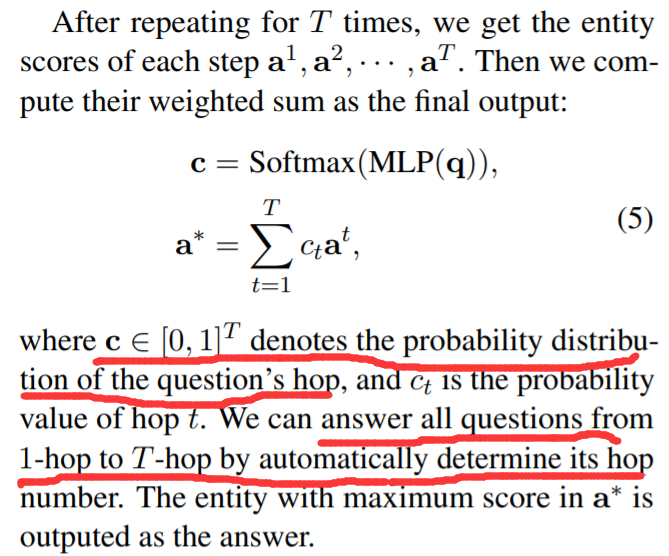

In [57]:
hop_res = torch.stack(ent_probs, dim=1) # [bsz, num_hop, num_ent]
hop_attn = torch.softmax(hop_selector(q_embeddings), dim=1).unsqueeze(2) # [bsz, num_hop, 1]
last_e = torch.sum(hop_res * hop_attn, dim=1) # [bsz, num_ent]

**最终的last_e不是利用最后一次hop的last_e，而是利用attention的方式计算最终的last_e**

## 计算Loss

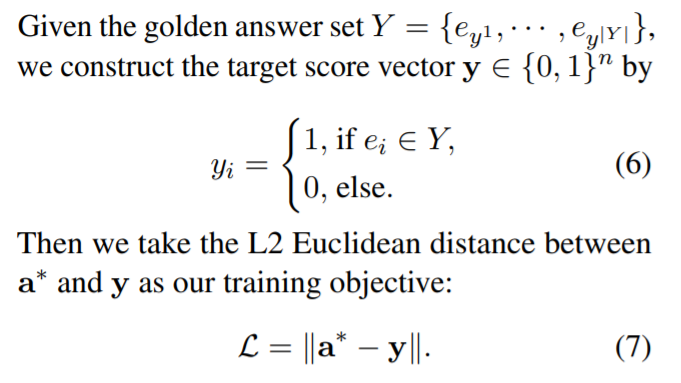

代码中不是采用简单的均方误差，而是做了一些trick

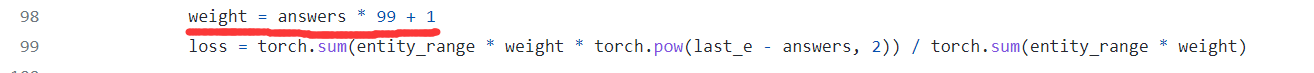

利用这个trick可以提高准确率 [代码细节分析](http://118.202.41.77:12321/notebooks/KG/Chinese_KGQA/12-15%20presentation/%E4%BB%A3%E7%A0%81%E7%BB%86%E8%8A%82%E5%88%86%E6%9E%90.ipynb)

In [64]:
sub_map['解构金庸']

[('出生地', '旧名竹堑，别号风城'),
 ('作者', '林保淳'),
 ('书名', '解构金庸'),
 ('别名', '解构金庸'),
 ('号称', '武林百晓生”')]

In [65]:
entity_range = set()
for p, o in sub_map[head]:
    entity_range.add(o)
    for p2, o2 in sub_map[o]:
        entity_range.add(o2)
entity_range = [ent2id[o] for o in entity_range]

In [66]:
entity_range

[151286, 12882, 116704, 51665, 18630, 110803, 41615]

In [67]:
id2ent={k:v for v,k in ent2id.items()}
[id2ent[id_] for id_ in entity_range]

['中国', '解构金庸', '1955年', '武林百晓生”', '《经世思想与文学经世》', '旧名竹堑，别号风城', '林保淳']

**以上就是“解构金庸”在KG中的2-hop路径上的所有实体**

In [69]:
entity_range=torch.nn.functional.one_hot(torch.LongTensor(entity_range),num_classes=len(ent2id))
answers=torch.nn.functional.one_hot(torch.LongTensor([ent2id[answer]]),num_classes=len(ent2id))
weight = answers * 99 + 1
loss=torch.sum(entity_range * weight * torch.pow(last_e - answers, 2)) / torch.sum(entity_range * weight)

In [70]:
loss

tensor(0.1410, grad_fn=<DivBackward0>)

**以上就是TransferNet模型的流程**